In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from cupyx.scipy import fft as cupyx_fft
from scipy import misc, fft as scipy_fft
import zarr
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, colors, cm
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
cp.cuda.set_pinned_memory_allocator(None)
mempool = cp.get_default_memory_pool()

In [3]:
# Plot functions

colors.get_named_colors_mapping().update({
    'lfd:signal': "#4e79a7",
    'lfd:pupil': "#59a14f",
    'lfd:retina': "#e15759",
    'lfd:filter': "#f28e2b",
})



# Basic array functions

def sampling_lattice(res, pitch=1.0):
    """Return an array of shape (res,) containing the coordinates of a sampling lattice with a given pitch in "standard" order (with zero at the start)."""
    return scipy_fft.fftfreq(res).astype(np.float32) * (res * pitch)

def display_image(values, color_map=None, absolute=True, normalize=True, shift=False, flip=False):
    """Display an array as an image using a color map. The image can be normalized, shifted and/or flipped."""
    values = np.abs(values) if absolute else values
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    values = scipy_fft.fftshift(values) if shift else values
    values = np.flip(values) if flip else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))

Discrete-time Fourier transform:
$$ \begin{align*}
    \hat{X}(\omega) = \text{DTFT}\{ x[n] \} = \sum_{n=-\infty}^{\infty} x[n] \, e^{-i \omega n} && (1.1)\\
\end{align*} $$

z-transform:
$$ \begin{align*}
    X(z) = \text{Z}\{ x[n] \} = \sum_{n=-\infty}^{\infty} x[n] \, z^{-n} && (1.2)\\
\end{align*} $$

Writing $z = re^{i \omega}$ we have:
$$ \begin{align*}
    X(re^{i \omega}) = \sum_{n=-\infty}^{\infty} x[n] \, \left(re^{i \omega}\right)^{-n} = \sum_{n=-\infty}^{\infty} x[n] \, r^{-n}e^{-i \omega n} = \text{DTFT}\{ x[n] \, r^{-n} \} && (1.3)\\
\end{align*} $$

Inverse DTFT:
$$ \begin{align*}
    x[n] = \text{DTFT}^{-1}\{ \hat{X}(\omega) \} = \frac{1}{2 \pi} \int_{2 \pi} \hat{X}(\omega) \, e^{i \omega n} \, \mathrm{d}\omega && (1.4)\\
\end{align*} $$

Inverse z-transform:
$$ \begin{align*}
    x[n] = \text{Z}^{-1}\{ X(z) \} = \frac{1}{2 \pi i} \oint_{C} X(z) \, z^{n - 1} \, \mathrm{d}z && (1.5)\\
\end{align*} $$

For $z = re^{i \omega}$ we have $\frac{\mathrm{d}z}{\mathrm{d}\omega} = r i e^{i \omega}$. Therefore, if we choose C as the circle of radius r we have:
$$ \begin{align*}
    x[n] &= \text{Z}^{-1}\{ X(re^{i \omega}) \} = \frac{1}{2 \pi i} \int_{2 \pi} X(re^{i \omega}) \, r^{n - 1}e^{i \omega (n-1)} \, r i e^{i \omega} \, \mathrm{d}\omega \\
    &= r^{n} \frac{1}{2 \pi} \int_{2 \pi} X(re^{i \omega}) \, e^{i \omega n} \, \mathrm{d}\omega = r^{n} \, \text{DTFT}^{-1}\{ X(re^{i \omega}) \} && (1.6)\\
\end{align*} $$

---

Let's consider $x[n] = a^n \, u[n] = [..., 0, 0, 0, \stackrel{n=0}{1}, a, a^2, a^3, ...]$. Its z-transform is:
$$ \begin{align*}
    X(z) = \sum_{n=-\infty}^{\infty} a^n \, u[n] \, z^{-n} = \sum_{n=0}^{\infty} \left(\frac{a}{z}\right)^n = \frac{1}{1 - \frac{a}{z}} = \frac{z}{z - a} \qquad \text{if} \; |z| > |a| && (2.1)\\
\end{align*} $$

Now let's consider $x[n] = -a^n \, u[-n-1] = [..., -a^{-3}, -a^{-2}, -a^{-1}, \stackrel{n=0}{0}, 0, 0, 0, ...]$. Its z-transform is:
$$ \begin{align*}
    X(z) &= \sum_{n=-\infty}^{\infty} -a^n \, u[-n-1] \, z^{-n} = -\sum_{n=-\infty}^{-1} \left(\frac{a}{z}\right)^n = -\sum_{n=1}^{\infty} \left(\frac{z}{a}\right)^n = 1 - \sum_{n=0}^{\infty} \left(\frac{z}{a}\right)^n \\
    &= 1 - \frac{1}{1 - \frac{z}{a}} = \frac{a-z}{a-z} - \frac{a}{a-z} = \frac{-z}{a-z} = \frac{z}{z-a} \qquad \text{if} \; |z| < |a| && (2.2)\\
\end{align*} $$

From the inverse z-transform perspective, let's consider $X(z) = \frac{z}{z-a} + \frac{z}{z-b}$, where $|b| > |a|$. From the linearity of the z-transform we have:
$$ \begin{align*}
    x[n] = \text{Z}^{-1}\bigg\{ \frac{z}{z-a} + \frac{z}{z-b} \bigg\} = \text{Z}^{-1}\bigg\{ \frac{z}{z-a} \bigg\} + \text{Z}^{-1}\bigg\{ \frac{z}{z-b} \bigg\} && (2.3)\\
\end{align*} $$

- If we assume the ROC to be $|z| > |b| > |a|$ we find:
$$ \begin{align*}
    x[n] = a^n \, u[n] + b^n \, u[n] = [...,\; 0 \;,\; 0 \;,\; 0 \;,\; \stackrel{n=0}{2} \;,\; a+b \;,\; a^2+b^2 \;,\; a^3+b^3 \;,...] && (2.4)\\
\end{align*} $$

- If we assume the ROC to be $|z| < |a| < |b|$ we find:
$$ \begin{align*}
    x[n] = -a^n \, u[-n-1] - b^n \, u[-n-1] = [...,\; -a^{-3}-b^{-3} \;,\; -a^{-2}-b^{-2} \;,\; -a^{-1}-b^{-1} \;,\; \stackrel{n=0}{0} \;,\; 0 \;,\; 0 \;,\; 0 \;,...] && (2.5)\\
\end{align*} $$

- If we assume the ROC to be $|a| < |z| < |b|$ we find:
$$ \begin{align*}
    x[n] = a^n \, u[n] - b^n \, u[-n-1] = [...,\; -b^{-3} \;,\; -b^{-2} \;,\; -b^{-1} \;,\; \stackrel{n=0}{1} \;,\; a \;,\; a^2 \;,\; a^3 \;,...] && (2.6)\\
\end{align*} $$

In the first case the ROC contains $z$ at infinity and therefore describes a causal system ($x[n] = 0 \; \forall \; n < 0$).

In the second case the ROC contains the origin and therefore describes an anti-causal system ($x[n] = 0 \; \forall \; n > 0$).

In the last case the ROC contains neither $z$ at infinity nor the origin and therefore describes a mixed-causality system.

---

Let's consider a translated signal $y[n] = x[n + k]$. Its z-transform is:
$$ \begin{align*}
    Y(z) = \sum_{n=-\infty}^{\infty} y[n] \, z^{-n} = \sum_{n=-\infty}^{\infty} x[n + k] \, z^{-n} = \sum_{n=-\infty}^{\infty} x[(n-k)+k] \, z^{-(n-k)} = z^{k} \sum_{n=-\infty}^{\infty} x[n] \, z^{-n} = z^{k} X(z) && (3.1)\\
\end{align*} $$

Note that, if $k > 0$, this procedure is adding $k$ zeros at $z = 0$ and $k$ poles at $z = \infty$. Analogously, if $k < 0$, this procedure is adding $-k$ zeros at $z = \infty$ and $-k$ poles at $z = 0$.
Also keep in mind that a zero and a pole at the same point cancel each other out.

Now let's consider $Y(z) = \frac{1}{z - a}$. Its inverse z-transform is:
$$ \begin{align*}
    y[n] = \text{Z}^{-1}\bigg\{ \frac{1}{z - a} \bigg\} = \text{Z}^{-1}\bigg\{ z^{-1} \frac{z}{z - a} \bigg\} = \text{Z}^{-1}\bigg\{ z^{-1} X(z) \bigg\} = x[n-1] \qquad \text{where} \; X(z) = \frac{z}{z - a} && (3.2)\\
\end{align*} $$

Note that $X(z)$ has one zero at $z = 0$ and one pole at $z = a$. The translation then added a zero at $z = \infty$ and a pole at $z = 0$.
After the translation the zero and the pole at $z = 0$ cancel each other out and $Y(z)$ has one zero at $z = \infty$ and one pole at $z = a$.

- If we assume the ROC to be $|z| > |a|$ we find:
$$ \begin{align*}
    y[n] = x[n-1] = a^{n-1} \, u[n-1] = [...,\; 0 \;,\; 0 \;,\; 0 \;,\; \stackrel{n=0}{0} \;,\; 1 \;,\; a \;,\; a^2 \;,...] && (3.3)\\
\end{align*} $$

- If we assume the ROC to be $|z| < |a|$ we find:
$$ \begin{align*}
    y[n] = x[n-1] = -a^{n-1} \, u[-n] = [...,\; -a^{-4} \;,\; -a^{-3} \;,\; -a^{-2} \;,\; \stackrel{n=0}{-a^{-1}} \;,\; 0 \;,\; 0 \;,\; 0 \;,...] && (3.4)\\
\end{align*} $$

The first case describes a causal system ($\infty \in$ ROC) while the second case describes an anti-causal system ($0 \in$ ROC).

If instead we did the translation twice, i.e., $k = -2$, we would have:
$$ \begin{align*}
    Y(z) = z^{-2} X(z) = \frac{1}{z(z - a)} && (3.5)\\
\end{align*} $$

Now $Y(z)$ has two zeros at $z = \infty$ and two poles, one at $z = a$ and one at $z = 0$.

- If we assume the ROC to be $|z| > |a| > 0$ we find:
$$ \begin{align*}
    y[n] = x[n-2] = a^{n-2} \, u[n-2] = [...,\; 0 \;,\; 0 \;,\; 0 \;,\; \stackrel{n=0}{0} \;,\; 0 \;,\; 1 \;,\; a \;,...] && (3.6)\\
\end{align*} $$

- If we assume the ROC to be $0 < |z| < |a|$ we find:
$$ \begin{align*}
    y[n] = x[n-2] = -a^{n-2} \, u[-n+1] = [...,\; -a^{-5} \;,\; -a^{-4} \;,\; -a^{-3} \;,\; \stackrel{n=0}{-a^{-2}} \;,\; -a^{-1} \;,\; 0 \;,\; 0 \;,...] && (3.7)\\
\end{align*} $$

The first case still describes a causal system ($\infty \in$ ROC) but the second case no longer describes an anti-causal system ($0 \notin$ ROC) which can be confirmed by $y[1] = -a^{-1} \neq 0$.

---

We are now interested in solving the inverse discrete convolution problem. For a given filter $h[n]$, the inverse filter $h^{-1}[n]$ is given by:
$$ \begin{align*}
    h^{-1}[n] = \text{Z}^{-1}\{ H^{-1}(z) \} = \text{Z}^{-1}\Bigg\{ \frac{1}{H(z)} \Bigg\} = \text{Z}^{-1}\Bigg\{ \frac{1}{\text{Z}\{h[n]\}} \Bigg\} && (4.1)\\
\end{align*} $$

Let's consider the filter $h[n] = [..., 0, 0, 1, \stackrel{n=0}{a}, b, 0, 0, ...]$. Its z-transform is:
$$ \begin{align*}
    H(z) = \sum_{n=-\infty}^{\infty} h[n] \, z^{-n} = z^{1} + az^{0} + bz^{-1} = \frac{z^2 + az + b}{z} \iff H^{-1}(z) = \frac{z}{z^2 + az + b} && (4.2)\\
\end{align*} $$

$H^{-1}(z)$ has two zeros, one at $z = 0$ and one at $z = \infty$, and two poles, one at $z = p_1$ and one at $z = p_2$, where $p_1$ and $p_2$ are the two solution to $z^2 + az + b = 0$. That is, $p_1 + p_2 = -a$ and $p_1 p_2 = b$.

We can then rewrite $H^{-1}(z)$ in terms of its poles:
$$ \begin{align*}
    H^{-1}(z) &= \frac{z}{(z - p_1)(z - p_2)} = \frac{(p_1 - p_2) z}{(p_1 - p_2)(z - p_1)(z - p_2)} = \frac{p_1(z - p_2) - p_2(z - p_1)}{(p_1 - p_2)(z - p_1)(z - p_2)} \\
    &= \frac{1}{p_1 - p_2} \left( p_1 \frac{1}{z - p_1} - p_2 \frac{1}{z - p_2} \right) = \frac{p_1}{p_1 - p_2} \left( \frac{1}{z - p_1} \right) + \frac{p_2}{p_2 - p_1} \left( \frac{1}{z - p_2} \right) && (4.3)\\
\end{align*} $$

Then the inverse filter is given by:
$$ \begin{align*}
    h^{-1}[n] = \underbrace{\frac{p_1}{p_1 - p_2} \text{Z}^{-1}\Bigg\{ \frac{1}{z - p_1} \Bigg\}}_{h_1^{-1}[n]} + \underbrace{\frac{p_2}{p_2 - p_1} \text{Z}^{-1}\Bigg\{ \frac{1}{z - p_2} \Bigg\}}_{h_2^{-1}[n]} && (4.4)\\
\end{align*} $$

From now on, let's assume $|p_1| \leq |p_2|$.

- If we assume the ROC to be $|z| > |p_2| \geq |p_1|$ we find:
$$ \begin{align*}
    h^{-1}[n] = \underbrace{\frac{p_1^{n}}{p_1 - p_2} u[n-1]}_{h_1^{-1}[n]} + \underbrace{\frac{p_{2}^{n}}{p_2 - p_1} u[n-1]}_{h_2^{-1}[n]}
    = [...,\; 0 \;,\; 0 \;,\; 0 \;,\; \stackrel{n=0}{0} \;,\; 1 \;,\; \frac{p_1^2-p_2^2}{p_1 - p_2} \;,\; \frac{p_1^3-p_2^3}{p_1 - p_2} \;,...] && (4.5)\\
\end{align*} $$

- If we assume the ROC to be $|z| < |p_1| \leq |p_2|$ we find:
$$ \begin{align*}
    h^{-1}[n] = \underbrace{\frac{-p_1^{n}}{p_1 - p_2} u[-n]}_{h_1^{-1}[n]} + \underbrace{\frac{-p_{2}^{n}}{p_2 - p_1} u[-n]}_{h_2^{-1}[n]}
    = [...,\; \frac{-p_1^{-3} + p_2^{-3}}{p_1 - p_2} \;,\; \frac{-p_1^{-2} + p_2^{-2}}{p_1 - p_2} \;,\; \frac{-p_1^{-1} + p_2^{-1}}{p_1 - p_2} \;,\; \stackrel{n=0}{0} \;,\; 0 \;,\; 0 \;,\; 0 \;,...] && (4.6)\\
\end{align*} $$

- If we assume $|p_1| \neq |p_2|$ and the ROC to be $|p_1| < |z| < |p_2|$ we find:
$$ \begin{align*}
    h^{-1}[n] = \underbrace{\frac{p_1^{n}}{p_1 - p_2} u[n-1]}_{h_1^{-1}[n]} + \underbrace{\frac{-p_2^{n}}{p_2 - p_1} u[-n]}_{h_2^{-1}[n]}
    = [...,\; \frac{p_2^{-3}}{p_1 - p_2} \;,\; \frac{p_2^{-2}}{p_1 - p_2} \;,\; \frac{p_2^{-1}}{p_1 - p_2} \;,\; \stackrel{n=0}{\frac{1}{p_1 - p_2}} \;,\; \frac{p_1}{p_1 - p_2} \;,\; \frac{p_1^{2}}{p_1 - p_2} \;,\; \frac{p_1^{3}}{p_1 - p_2} \;,...] && (4.7)\\
\end{align*} $$

---

Convolution is distributive over addition, therefore:
$$ \begin{align*}
    y[n] = x[n] * h^{-1}[n] = x[n] * (h_1^{-1}[n] + h_2^{-1}[n]) = (x[n] * h_1^{-1}[n]) + (x[n] * h_2^{-1}[n]) = y_1[n] + y_2[n] && (5.1)\\
\end{align*} $$

We can derive a recursive formulation for the convolution with $h_1^{-1}[n]$ and $h_2^{-1}[n]$ in each case.

- Causal subfilter: $h_1^{-1}[n] = \frac{p_1^{n}}{p_1 - p_2} u[n-1]$
$$ \begin{align*}
    y_1[n] = h_1^{-1}[n] * x[n] = \sum_{k=-\infty}^{\infty} h_1^{-1}[k] \, x[n - k] = \sum_{k=-\infty}^{\infty} \frac{p_1^{k}}{p_1 - p_2} u[k-1] \, x[n - k] = \sum_{k=1}^{\infty} \frac{p_1^{k}}{p_1 - p_2} x[n - k] && (5.2)\\
    y_1[n+1] = \sum_{k=1}^{\infty} \frac{p_1^{k}}{p_1 - p_2} x[n + 1 - k] = \sum_{k=0}^{\infty} \frac{p_1^{k+1}}{p_1 - p_2} x[n - k] = \frac{p_1}{p_1 - p_2}x[n] + \sum_{k=1}^{\infty} \frac{p_1^{k+1}}{p_1 - p_2} x[n - k]\\
    = \frac{p_1}{p_1 - p_2}x[n] + p_1 \sum_{k=1}^{\infty} \frac{p_1^{k}}{p_1 - p_2} x[n - k] = \frac{p_1}{p_1 - p_2}x[n] + p_1 y_1[n] = p_1 \left( y_1[n] + \frac{x[n]}{p_1 - p_2} \right) && (5.3)\\
    \text{analogously} \qquad y_2[n+1] = p_2 \left( y_2[n] + \frac{x[n]}{p_2 - p_1} \right) && (5.4)\\
\end{align*} $$

- Anti-causal subfilter: $h_1^{-1}[n] = \frac{-p_1^{n}}{p_1 - p_2} u[-n]$
$$ \begin{align*}
    y_1[n] = h_1^{-1}[n] * x[n] = \sum_{k=-\infty}^{\infty} h_1^{-1}[k] \, x[n - k] = \sum_{k=-\infty}^{\infty} \frac{-p_1^{k}}{p_1 - p_2} u[-k] \, x[n - k] = \sum_{k=-\infty}^{0} \frac{-p_1^{k}}{p_1 - p_2} x[n - k] && (5.5)\\
    y_1[n-1] = \sum_{k=-\infty}^{0} \frac{-p_1^{k}}{p_1 - p_2} x[n - 1 - k] = \sum_{k=-\infty}^{1} \frac{-p_1^{k-1}}{p_1 - p_2} x[n - k] = \frac{-1}{p_1 - p_2}x[n-1] + \sum_{k=-\infty}^{0} \frac{-p_1^{k-1}}{p_1 - p_2} x[n - k]\\
    = \frac{-1}{p_1 - p_2}x[n-1] + p_1^{-1} \sum_{k=-\infty}^{0} \frac{-p_1^{k}}{p_1 - p_2} x[n - k] = \frac{-1}{p_1 - p_2}x[n-1] + p_1^{-1} y_1[n]\\
    \therefore \quad p_1 y_1[n-1] = \frac{-p_1}{p_1 - p_2}x[n-1] + y_1[n] \therefore y_1[n] = \frac{p_1}{p_1 - p_2}x[n-1] + p_1 y_1[n-1] \therefore y_1[n+1] = p_1 \left( y_1[n] + \frac{x[n]}{p_1 - p_2} \right) && (5.6)\\
    \text{analogously} \qquad y_2[n+1] = p_2 \left( y_2[n] + \frac{x[n]}{p_2 - p_1} \right) && (5.7)\\
\end{align*} $$

Note that the recursive formulae are the same regardless of the causality of the subfilters: (5.3) = (5.6), (5.4) = (5.7).

---

Now we want to verify that all 3 cases above, (4.5), (4.6) and (4.7), are valid inverse filters by cheking if $\delta[n] = h[n] * h^{-1}[n] = (h[n] * h_1^{-1}[n]) + (h[n] * h_2^{-1}[n])$.

First we evaluate each subfilter convolution at $n=0$.

- Causal subfilter: $h_1^{-1}[n] = \frac{p_1^{n}}{p_1 - p_2} u[n-1]$
$$ \begin{align*}
    y_1[0] = (h * h_1^{-1})[0] = h_1^{-1}[1] + ah_1^{-1}[0] + bh_1^{-1}[-1] = \frac{p_1^{1}}{p_1 - p_2} u[1-1] + a\frac{p_1^{0}}{p_1 - p_2} u[0-1] + b\frac{p_1^{-1}}{p_1 - p_2} u[-1-1] = \frac{p_1}{p_1 - p_2} && (6.1)\\
    \text{analogously} \qquad y_2[0] = \frac{p_2}{p_2 - p_1} && (6.2)\\
\end{align*} $$

- Anti-causal subfilter: $h_1^{-1}[n] = \frac{-p_1^{n}}{p_1 - p_2} u[-n]$
$$ \begin{align*}
    y_1[0] = (h * h_1^{-1})[0] = h_1^{-1}[1] + ah_1^{-1}[0] + bh_1^{-1}[-1] = \frac{-p_1^{1}}{p_1 - p_2} u[-1] + a\frac{-p_1^{0}}{p_1 - p_2} u[0] + b\frac{-p_1^{-1}}{p_1 - p_2} u[-(-1)] = -a\frac{1}{p_1 - p_2} - b\frac{p_1^{-1}}{p_1 - p_2}\\
    = (p_1 + p_2) \frac{1}{p_1 - p_2} - (p_1 p_2) \frac{p_1^{-1}}{p_1 - p_2} = \frac{p_1}{p_1 - p_2} + \frac{p_2}{p_1 - p_2} - \frac{p_2}{p_1 - p_2} = \frac{p_1}{p_1 - p_2} && (6.3)\\
    \text{analogously} \qquad y_2[0] = \frac{p_2}{p_2 - p_1} && (6.4)\\
\end{align*} $$

Regardless of the combination of causal or anti-causal subfilters, we have $y[0] = y_1[0] + y_2[0] = \frac{p_1}{p_1 - p_2} + \frac{p_2}{p_2 - p_1} = \frac{p_1 - p_2}{p_1 - p_2} = 1 = \delta[0]$.

Now we use the recursive formulae to prove that $y[n] = 0$ for all values of $n \neq 0$.

- $n = 1$
$$ \begin{align*}
    y_1[1] = p_1 \left( y_1[0] + \frac{h[0]}{p_1 - p_2} \right) = p_1 \left( \frac{p_1}{p_1 - p_2} + \frac{a}{p_1 - p_2} \right) = p_1 \left( \frac{p_1 - (p_1 + p_2)}{p_1 - p_2} \right) = \frac{-p_1 p_2}{p_1 - p_2}\\
    \text{analogously} \qquad y_2[1] = \frac{-p_1 p_2}{p_2 - p_1}\\
    y[1] = y_1[1] + y_2[1] = \frac{-p_1 p_2}{p_1 - p_2} + \frac{-p_1 p_2}{p_2 - p_1} = \frac{p_1 p_2 - p_1 p_2}{p_1 - p_2} = 0\\
\end{align*} $$
- $n = 2$
$$ \begin{align*}
    y_1[2] = p_1 \left( y_1[1] + \frac{h[1]}{p_1 - p_2} \right) = p_1 \left( \frac{-p_1 p_2}{p_1 - p_2} + \frac{b}{p_1 - p_2} \right) = p_1 \left( \frac{-p_1 p_2 + (p_1 p_2)}{p_1 - p_2} \right) = 0\\
    \text{analogously} \qquad y_2[2] = 0\\
    y[2] = y_1[2] + y_2[2] = 0 + 0 = 0\\
\end{align*} $$
- $n > 2$, assuming $y_1[n-1]=0$
$$ \begin{align*}
    y_1[n] = p_1 \left( y_1[n-1] + \frac{h[n-1]}{p_1 - p_2} \right) = p_1 \left( 0 + \frac{0}{p_1 - p_2} \right) = 0\\
    \text{analogously} \qquad y_2[n] = 0\\
    y[n] = y_1[n] + y_2[n] = 0 + 0 = 0\\
\end{align*} $$
- $n = -1$
$$ \begin{align*}
    y_1[0] = p_1 \left( y_1[-1] + \frac{h[-1]}{p_1 - p_2} \right) \therefore y_1[-1] = p_1^{-1} y_1[0] - \frac{h[-1]}{p_1 - p_2} = p_1^{-1} \frac{p_1}{p_1 - p_2} - \frac{1}{p_1 - p_2} = \frac{1 - 1}{p_1 - p_2} = 0\\
    \text{analogously} \qquad y_2[-1] = 0\\
    y[-1] = y_1[-1] + y_2[-1] = 0 + 0 = 0\\
\end{align*} $$
- $n < -1$, assuming $y_1[n+1]=0$
$$ \begin{align*}
    y_1[n+1] = p_1 \left( y_1[n] + \frac{h[n]}{p_1 - p_2} \right) \therefore y_1[n] = p_1^{-1} y_1[n+1] - \frac{h[n]}{p_1 - p_2} = p_1^{-1} 0 - \frac{0}{p_1 - p_2} = 0\\
    \text{analogously} \qquad y_2[n] = 0\\
    y[n] = y_1[n] + y_2[n] = 0 + 0 = 0\\
\end{align*} $$

---

Let's consider the filter $h[n] = [..., 0, 0, 0, a_{-N}, a_{-N+1}, a_{-N+2}, ..., a_{-2}, a_{-1}, \stackrel{n=0}{a_{0}}, a_{1}, a_{2}, ..., a_{N-2}, a_{N-1}, a_{N}, 0, 0, 0, ...]$. Its z-transform is:
$$ \begin{align*}
    H(z) &= \sum_{n=-\infty}^{\infty} h[n] \, z^{-n} = \sum_{n=-N}^{N} a_{n} \, z^{-n} = \sum_{n=0}^{2N} a_{N-n} \, z^{n-N} = z^{-N} \sum_{n=0}^{2N} a_{N-n} \, z^{n} = a_{-N} z^{-N} \sum_{n=0}^{2N} \frac{a_{N-n}}{a_{-N}} \, z^{n}\\
    &= a_{-N} z^{-N} \left( \frac{a_N}{a_{-N}} + \frac{a_{N-1}}{a_{-N}}z + \frac{a_{N-2}}{a_{-N}}z^2 + ... + \frac{a_{0}}{a_{-N}}z^N + ... + \frac{a_{-N+1}}{a_{-N}}z^{2N-1} + z^{2N} \right)\\
    &= a_{-N} z^{-N} \prod_{k=1}^{2N} (z - p_{k}) = a_{-N} z^{-N} \prod_{k=1}^{N} (z - p_{2k-1})(z - p_{2k}) = a_{-N} \prod_{k=1}^{N} \frac{(z - p_{2k-1})(z - p_{2k})}{z}
    \iff H^{-1}(z) = a_{-N}^{-1} \prod_{k=1}^{N} \frac{z}{(z - p_{2k-1})(z - p_{2k})} && (7.1)\\
\end{align*} $$

The inverse filter is then given by:

$$ \begin{align*}
    h^{-1}[n] = a_{-N}^{-1} \stackrel{N}{\underset{k=1}{\circledast}} \text{Z}^{-1}\Bigg\{ \frac{z}{(z - p_{2k-1})(z - p_{2k})} \Bigg\}
    = a_{-N}^{-1} \stackrel{N}{\underset{k=1}{\circledast}} \left( \frac{p_{2k-1}}{p_{2k-1} - p_{2k}} \text{Z}^{-1}\Bigg\{ \frac{1}{z - p_{2k-1}} \Bigg\}
    + \frac{p_{2k}}{p_{2k} - p_{2k-1}} \text{Z}^{-1}\Bigg\{ \frac{1}{z - p_{2k}} \Bigg\} \right) && (7.2)\\
\end{align*} $$

---

If a filter is real, i.e., $h[n] = \bar{h}[n]$, we have:
$$ \begin{align*}
    H(z) = \sum_{n=-\infty}^{\infty} h[n] \, z^{-n} = \sum_{n=-\infty}^{\infty} \bar{h}[n] \, z^{-n}
    \sum_{n=-\infty}^{\infty} \overline{\left( h[n] \, \overline{z^{-n}} \right)} = \sum_{n=-\infty}^{\infty} \overline{\left( h[n] \, \bar{z}^{-n} \right)} = \bar{H}(\bar{z}) && (8.1)\\
\end{align*} $$

If $p$ is a pole of $H(z)$, then $\bar{p}$ is also a pole of $H(z)$.

From (8.1), it follows that:
$$ \begin{align*}
    H^{-1}(z) = \frac{1}{H(z)} = \frac{1}{\bar{H}(\bar{z})} = \bar{H}^{-1}(\bar{z}) && (8.2)\\
\end{align*} $$

Note that $h[n]$ being real implies that $h^{-1}[n]$ must also be real. This is only true because $z$ being in the ROC implies that $\bar{z}$ must also be in the ROC.

For a pair of poles $p_1$ and $p_2$ where $p_2 = \bar{p}_1$, we will have $h_2^{-1}[n] = \bar{h}_1^{-1}[n]$.
Therefore, $h^{-1}[n] = h_1^{-1}[n] + h_2^{-1}[n] = h_1^{-1}[n] + \bar{h}_1^{-1}[n] = 2 \, \mathfrak{Re}\big\{ h_1^{-1}[n] \big\}$.

---

If a filter is symmetric, i.e., $h[n] = h[-n]$, we have:
$$ \begin{align*}
    H(z) = \sum_{n=-\infty}^{\infty} h[n] \, z^{-n} = \sum_{n=-\infty}^{\infty} h[-n] \, z^{-n} = \sum_{n=-\infty}^{\infty} h[n] \, (z^{-1})^{-n} = H(z^{-1}) \qquad \text{where} \; z^{-1} = \frac{\bar{z}}{|z|^2} && (9.1)\\
\end{align*} $$

Note that if $p$ is a pole of $H(z)$, then $p^{-1}$ is also a pole of $H(z)$.

From (9.1), it follows that:
$$ \begin{align*}
    H^{-1}(z) = \frac{1}{H(z)} = \frac{1}{H(z^{-1})} = H^{-1}(z^{-1}) && (9.2)\\
\end{align*} $$

Note, however, that $h[n]$ being symmetric does **not** imply that $h^{-1}[n]$ must also be symmetric. This is due to the fact that $z$ being in the ROC does **not** imply that $z^{-1}$ must also be in the ROC.

If $H^{-1}[n]$ has no poles on the unit circle and $p$ is the largest pole of $H^{-1}[n]$ inside the unit circle,
then $p^{-1}[n]$ is the smallest pole outside the unit circle and the ROC defined by $|p| < |z| < |p^{-1}|$ is the only one that yields a symmetric $h^{-1}[n]$.

However, if $h[n]$ is symmetric and $h^{-1}[n]$ is an asymmetric inverse filter of $h[n]$, then $h^{-1}[-n]$ is also an inverse filter of $h[n]$:
$$ \begin{align*}
    \delta[n] = h[n] * h^{-1}[n] = \sum_{n=-\infty}^{\infty} h[n] \, h^{-1}[-n] = \sum_{n=-\infty}^{\infty} h[-n] \, h^{-1}[-n] = \sum_{n=-\infty}^{\infty} h[n] \, h^{-1}[-(-n)] = h[n] * h^{-1}[-n] && (9.3)\\
\end{align*} $$

These pairs of reflective inverses are related to the pairs of ROCs $|p_j| < |z| < |p_k|$ and $|p_k^{-1}| < |z| < |p_j^{-1}|$ (or the pair of causal and anti-causal ROCs $|z| < |p|$ and $|p^{-1}| < |z|$).

---

Let's consider the symmetric filter $h[n] = [..., 0, 0, 1, \stackrel{n=0}{a}, 1, 0, 0, ...]$. Which is the same as we have seen before for $b = 1$. Note that, as expected, $p_1 p_2 = b = 1 \iff p_2 = p_1^{-1}$.

From now on, let's call the poles $p$ and $p^{-1}$ and assume $|p| \leq 1 \leq |p^{-1}|$.

- If we assume the ROC to be $|z| > |p^{-1}| \geq |p|$ we find:
$$ \begin{align*}
    h^{-1}[n] = \underbrace{\frac{p^{n}}{p - p^{-1}} u[n-1]}_{h_1^{-1}[n]} + \underbrace{\frac{p^{-n}}{p^{-1} - p} u[n-1]}_{h_2^{-1}[n]}
    = [...,\; 0 \;,\; 0 \;,\; 0 \;,\; \stackrel{n=0}{0} \;,\; 1 \;,\; \frac{p^2-p^{-2}}{p - p^{-1}} \;,\; \frac{p^3-p^{-3}}{p - p^{-1}} \;,...] && (10.1)\\
\end{align*} $$

- If we assume the ROC to be $|z| < |p| \leq |p^{-1}|$ we find:
$$ \begin{align*}
    h^{-1}[n] = \underbrace{\frac{-p^{n}}{p - p^{-1}} u[-n]}_{h_1^{-1}[n]} + \underbrace{\frac{-p^{-n}}{p^{-1} - p} u[-n]}_{h_2^{-1}[n]}
    = [...,\; \frac{p^{3} - p^{-3}}{p - p^{-1}} \;,\; \frac{p^{2} - p^{-2}}{p - p^{-1}} \;,\; 1 \;,\; \stackrel{n=0}{0} \;,\; 0 \;,\; 0 \;,\; 0 \;,...] && (10.2)\\
\end{align*} $$

- If we assume $|p| \neq |p^{-1}|$ and the ROC to be $|p| < |z| < |p^{-1}|$ we find:
$$ \begin{align*}
    h^{-1}[n] = \underbrace{\frac{p^{n}}{p - p^{-1}} u[n-1]}_{h_1^{-1}[n]} + \underbrace{\frac{-p^{-n}}{p_2 - p} u[-n]}_{h_2^{-1}[n]}
    = [...,\; \frac{p^{3}}{p - p^{-1}} \;,\; \frac{p^{2}}{p - p^{-1}} \;,\; \frac{p}{p - p^{-1}} \;,\; \stackrel{n=0}{\frac{1}{p - p^{-1}}} \;,\; \frac{p}{p - p^{-1}} \;,\; \frac{p^{2}}{p - p^{-1}} \;,\; \frac{p^{3}}{p - p^{-1}} \;,...]
    = \frac{p^{|n|}}{p - p^{-1}} && (10.3)\\
\end{align*} $$

Note that, as expected, the inverse filters in (10.1) and (10.2) are reflexes of each other. Also note that the inverse filter in (10.3) is symmetric and is the only stable inverse filter (if it exists).

If $a$ is real, then the poles are $p$ and $\bar{p}$, and moreover $\bar{p} = p^{-1}$. Therefore $|p| = |\bar{p}| = |p^{-1}| = 1$ and there is no stable inverse filter, that is, (10.3) is invalid.

The causal inverse filter in (10.1) becomes:
$$ \begin{align*}
    h^{-1}[n] = \frac{\mathfrak{Im}\{ p^{n} \}}{\mathfrak{Im}\{ p \}} u[n] && (10.4)\\
\end{align*} $$


And the anti-causal inverse filter in (10.2) becomes:
$$ \begin{align*}
    h^{-1}[n] = \frac{\mathfrak{Im}\{ p^{-n} \}}{\mathfrak{Im}\{ p \}} u[-n] && (10.5)\\
\end{align*} $$

---

Let's consider the real and symmetric box filter $h[n] = [..., 0, 0, 1, \stackrel{n=0}{1}, 1, 0, 0, ...]$.

Its z-transform is $H(z) = z + 1 + z^{-1} = \frac{z^2 + z + 1}{z}$.

The inverse transfer function is $H^{-1}(z) = \frac{z}{z^2 + z + 1}$ which has two poles, $p_1 = -\frac{1}{2} + \frac{\sqrt{3}}{2}i$ and $p_2 = -\frac{1}{2} - \frac{\sqrt{3}}{2}i$, both on the unit circle.

The argument of $p_1$ and $p_2$ are $\frac{2 \pi}{3}$ and $-\frac{2 \pi}{3} = \frac{4 \pi}{3}$, respectively. Therefore, $p_1^2 = p_2$, $p_1^3 = p_1^0 = 1$ and $p_1^4 = p_1$.

The causal inverse filter described by (10.4) then becomes:
$$ \begin{align*}
    h^{-1}[n] = [...,\; 0 \;,\; 0 \;,\; 0 \;,\; \stackrel{n=0}{0} \;,\; 1 \;,\; -1 \;,\; 0 \;,\; 1 \;,\; -1 \;,\; 0 \;,...] && (11.1)\\
\end{align*} $$

A recursive formulation for the convolution can also be derived: $y[n] = x[n-1] - x[n-2] + y[n-3]$.

---

There are two different contexts where an inverse filter $h^{-1}[n]$ might be used:
1. The finite output signal $y[n]$ is given, where $y[n] = x[n] * h[n]$ for some unkown finite input signal $x[n]$, and we want to recover $x[n]$. That is, $x[n] = \left( x[n] * h[n] \right) * h^{-1}[n]$.
2. There is a desired finite output signal $y[n]$ and we want to find a finite input signal $x[n]$ that yields $y[n] = x[n] * h[n]$. That is, $y[n] = \left( y[n] * h^{-1}[n] \right) * h[n]$.

Let's consider the finite input signal $x[n] = [..., 0, 0, x_{-1}, \stackrel{n=0}{x_{0}}, x_{1}, 0, 0, ...]$.

If $x[n]$ is convolved with the box filter of size 3, we will have the finite output signal
$y[n] = x[n] * h[n] = [...,\; 0 \;,\; 0 \;,\; x_{-1} \;,\; x_{-1}+x_{0} \;,\; \stackrel{n=0}{x_{-1}+x_{0}+x_{1}} \;,\; x_{0}+x_{1} \;,\; x_{1} \;,\; 0 \;,\; 0 \;,...]$.

If we then convolve this result with $h^{-1}[n]$ we recover $x[n]$:
$$ \begin{align*}
    x[..., -3, -2] &= 0 \\
    x[-1] &= y[-2] = x_{-1} \\
    x[0] &= y[-1] - y[-2] = (x_{-1}+x_{0}) - x_{-1} = x_{0} \\
    x[1] &= y[0] - y[-1] = (x_{-1}+x_{0}+x_{1}) - (x_{-1}+x_{0}) = x_{1} \\
    x[2, 5, 8, ...] &= (0)y[2] + (1)y[1] + (-1)y[0] + (0)y[-1] + (1)y[-2] = (x_{0}+x_{1}) - (x_{-1}+x_{0}+x_{1}) + (x_{-1}) = 0 \\
    x[3, 6, 9, ...] &= (1)y[2] + (-1)y[1] + (0)y[0] + (1)y[-1] + (-1)y[-2] = x_{1} - (x_{0}+x_{1}) + (x_{-1}+x_{0}) - (x_{-1}) = 0 \\
    x[4, 7, 10, ...] &= (-1)y[2] + (0)y[1] + (1)y[0] + (-1)y[-1] + (0)y[-2] = -x_{1} + (x_{-1}+x_{0}+x_{1}) - (x_{-1}+x_{0}) = 0 \\
\end{align*} $$

Now let's consider instead the finite output signal $y[n] = [..., 0, 0, y_{-2}, y_{-1}, \stackrel{n=0}{y_{0}}, y_{1}, y_{2}, 0, 0, ...]$.

If $y[n]$ is convolved with $h^{-1}[n]$, we find:
$$ \begin{align*}
    x[n] = [...,\; 0 \;,\; 0 \;,\; y_{-2} \;,\; \stackrel{n=0}{y_{-1} - y_{-2}} \;,\; y_{0} - y_{-1}
    \;,\; y_{1} - y_{0} + y_{-2} \;,\; y_{2} - y_{1} + y_{-1} - y_{-2} \;,\; -y_{2} + y_{0} - y_{-1}
    \;,\; y_{1} - y_{0} + y_{-2} \;,\; y_{2} - y_{1} + y_{-1} - y_{-2} \;,\; -y_{2} + y_{0} - y_{-1} \;, ...] && (12.1) \\
\end{align*} $$

Note that from (12.1) there is no guarantee that $x[n]$ is finite. However, if we are only concerned with correctly reproducing the values ​​of $y[n]$ in the specified finite range,
we can use the finite support of $h[n]$ to constrain the required values of $x[n]$.

$$ \begin{align*}
    \tilde{x}[n] = [...,\; 0 \;,\; 0 \;,\; y_{-2} \;,\; \stackrel{n=0}{y_{-1} - y_{-2}} \;,\; y_{0} - y_{-1}
    \;,\; y_{1} - y_{0} + y_{-2} \;,\; y_{2} - y_{1} + y_{-1} - y_{-2} \;,\; 0 \;,\; 0 \;, ...] && (12.2) \\
\end{align*} $$

Finally, we convolve $\tilde{x}[n]$ result with $h[n]$:
$$ \begin{align*}
    \tilde{y}[n] = [...,\; 0 \;,\; 0 \;,\; y_{-2} \;,\; y_{-1} \;,\; \stackrel{n=0}{y_{0}} \;,\; y_{1} \;,\; y_{2}
    \;,\; y_{2} - y_{0} + y_{-1} \;,\; y_{2} - y_{1} + y_{-1} - y_{-2} \;,\; 0 \;,\; 0 \;, ...] && (12.3) \\
\end{align*} $$

---

The matrix form of the first problem is:
$$ \begin{align*}
    \begin{bmatrix} y_{-2} \\ y_{-1} \\ y_{0} \\ y_{1} \\ y_{2} \end{bmatrix} =
    \begin{bmatrix}
        1 & 0 & 0 \\
        1 & 1 & 0 \\
        1 & 1 & 1 \\
        0 & 1 & 1 \\
        0 & 0 & 1 \\
    \end{bmatrix}
    \begin{bmatrix} x_{-1} \\ x_{0} \\ x_{1} \end{bmatrix}
    = \begin{bmatrix} x_{-1} \\ x_{-1}+x_{0} \\ x_{-1}+x_{0}+x_{1} \\ x_{0}+x_{1} \\ x_{1} \end{bmatrix} && (13.1)\\
\end{align*} $$

Two solutions are given by:
$$ \begin{align*}
    \begin{bmatrix}
        0 & 0 & 1 & -1 & 0 \\
        0 & 0 & 0 & 1 & -1 \\
        0 & 0 & 0 & 0 & 1 \\
    \end{bmatrix}
    \begin{bmatrix}
        1 & 0 & 0 \\
        1 & 1 & 0 \\
        1 & 1 & 1 \\
        0 & 1 & 1 \\
        0 & 0 & 1 \\
    \end{bmatrix}
    = \begin{bmatrix}
        1 & 0 & 0 \\
        0 & 1 & 0 \\
        0 & 0 & 1 \\
    \end{bmatrix} && (13.2) \\ \\
    \begin{bmatrix}
        1 & 0 & 0 & 0 & 0 \\
        -1 & 1 & 0 & 0 & 0 \\
        0 & -1 & 1 & 0 & 0 \\
    \end{bmatrix}
    \begin{bmatrix}
        1 & 0 & 0 \\
        1 & 1 & 0 \\
        1 & 1 & 1 \\
        0 & 1 & 1 \\
        0 & 0 & 1 \\
    \end{bmatrix}
    = \begin{bmatrix}
        1 & 0 & 0 \\
        0 & 1 & 0 \\
        0 & 0 & 1 \\
    \end{bmatrix} && (13.3) \\
\end{align*} $$

Pseudoinverse:
$$ \begin{align*}
    A &= \begin{bmatrix}
        1 & 0 & 0 \\
        1 & 1 & 0 \\
        1 & 1 & 1 \\
        0 & 1 & 1 \\
        0 & 0 & 1 \\
    \end{bmatrix} \qquad \therefore \qquad A^{+} = \frac{1}{8}
    \begin{bmatrix}
        5 & 1 & 2 & -3 & 1 \\
        -4 & 4 & 0 & 4 & -4 \\
        1 & -3 & 2 & 1 & 5 \\
    \end{bmatrix} && (13.4) \\
\end{align*} $$

$$ \begin{align*}
    \frac{1}{8} \begin{bmatrix}
        5 & 1 & 2 & -3 & 1 \\
        -4 & 4 & 0 & 4 & -4 \\
        1 & -3 & 2 & 1 & 5 \\
    \end{bmatrix}
    \begin{bmatrix}
        1 & 0 & 0 \\
        1 & 1 & 0 \\
        1 & 1 & 1 \\
        0 & 1 & 1 \\
        0 & 0 & 1 \\
    \end{bmatrix}
    = \begin{bmatrix}
        1 & 0 & 0 \\
        0 & 1 & 0 \\
        0 & 0 & 1 \\
    \end{bmatrix} && (13.5) \\
\end{align*} $$

The matrix form of the second problem is:

$$ \begin{align*}
    \begin{bmatrix} y_{-2} \\ y_{-1} \\ y_{0} \\ y_{1} \\ y_{2} \end{bmatrix} =
    \begin{bmatrix}
        1 & 1 & 1 & 0 & 0 & 0 & 0 \\
        0 & 1 & 1 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 1 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 1 & 1 & 0 \\
        0 & 0 & 0 & 0 & 1 & 1 & 1 \\
    \end{bmatrix}
    \begin{bmatrix} x_{-3} \\ x_{-2} \\ x_{-1} \\ x_{0} \\ x_{1} \\ x_{2} \\ x_{3} \end{bmatrix}
    = \begin{bmatrix} x_{-3}+x_{-2}+x_{-1} \\ x_{-2}+x_{-1}+x_{0} \\ x_{-1}+x_{0}+x_{1} \\ x_{0}+x_{1}+x_{2} \\ x_{1}+x_{2}+x_{3} \end{bmatrix} && (13.6)\\
\end{align*} $$

Two solutions are given by:
$$ \begin{align*}
    \begin{bmatrix}
        1 & 1 & 1 & 0 & 0 & 0 & 0 \\
        0 & 1 & 1 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 1 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 1 & 1 & 0 \\
        0 & 0 & 0 & 0 & 1 & 1 & 1 \\
    \end{bmatrix}
    \begin{bmatrix}
        1 & -1 & 0 & 1 & -1 \\
        0 & 1 & -1 & 0 & 1 \\
        0 & 0 & 1 & -1 & 0 \\
        0 & 0 & 0 & 1 & -1 \\
        0 & 0 & 0 & 0 & 1 \\
        0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 \\
    \end{bmatrix}
    = \begin{bmatrix}
        1 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0 & 1 \\
    \end{bmatrix} && (13.7) \\ \\
    \begin{bmatrix}
        1 & 1 & 1 & 0 & 0 & 0 & 0 \\
        0 & 1 & 1 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 1 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 1 & 1 & 0 \\
        0 & 0 & 0 & 0 & 1 & 1 & 1 \\
    \end{bmatrix}
    \begin{bmatrix}
        0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 \\
        1 & 0 & 0 & 0 & 0 \\
        -1 & 1 & 0 & 0 & 0 \\
        0 & -1 & 1 & 0 & 0 \\
        1 & 0 & -1 & 1 & 0 \\
        -1 & 1 & 0 & -1 & 1 \\
    \end{bmatrix}
    = \begin{bmatrix}
        1 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0 & 1 \\
    \end{bmatrix} && (13.8) \\
\end{align*} $$

Pseudoinverse:
$$ \begin{align*}
    A &= \begin{bmatrix}
        1 & 1 & 1 & 0 & 0 & 0 & 0 \\
        0 & 1 & 1 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 1 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 1 & 1 & 0 \\
        0 & 0 & 0 & 0 & 1 & 1 & 1 \\
    \end{bmatrix} \qquad \therefore \qquad A^{+} = \frac{1}{16}
    \begin{bmatrix}
        12 & -10 & 0 & 6 & -4 \\
        2 & 9 & -8 & 1 & 2 \\
        2 & 1 & 8 & -7 & 2 \\
        -4 & 6 & 0 & 6 & -4 \\
        2 & -7 & 8 & 1 & 2 \\
        2 & 1 & -8 & 9 & 2 \\
        -4 & 6 & 0 & -10 & 12 \\
    \end{bmatrix} && (13.9) \\
\end{align*} $$

$$ \begin{align*}
    \begin{bmatrix}
        1 & 1 & 1 & 0 & 0 & 0 & 0 \\
        0 & 1 & 1 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 1 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 1 & 1 & 0 \\
        0 & 0 & 0 & 0 & 1 & 1 & 1 \\
    \end{bmatrix}
    \frac{1}{16} \begin{bmatrix}
        12 & -10 & 0 & 6 & -4 \\
        2 & 9 & -8 & 1 & 2 \\
        2 & 1 & 8 & -7 & 2 \\
        -4 & 6 & 0 & 6 & -4 \\
        2 & -7 & 8 & 1 & 2 \\
        2 & 1 & -8 & 9 & 2 \\
        -4 & 6 & 0 & -10 & 12 \\
    \end{bmatrix}
    = \begin{bmatrix}
        1 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0 & 1 \\
    \end{bmatrix} && (13.10) \\
\end{align*} $$

And a problem with square matrix:
$$ \begin{align*}
    \begin{bmatrix} y_{-2} \\ y_{-1} \\ y_{0} \\ y_{1} \\ y_{2} \end{bmatrix} =
    \begin{bmatrix}
        2 & 1 & 0 & 0 & 0 \\
        1 & 1 & 1 & 0 & 0 \\
        0 & 1 & 1 & 1 & 0 \\
        0 & 0 & 1 & 1 & 1 \\
        0 & 0 & 0 & 1 & 2 \\
    \end{bmatrix}
    \begin{bmatrix} x_{-2} \\ x_{-1} \\ x_{0} \\ x_{1} \\ x_{2} \end{bmatrix}
    = \begin{bmatrix} 2x_{-2}+x_{-1} \\ x_{-2}+x_{-1}+x_{0} \\ x_{-1}+x_{0}+x_{1} \\ x_{0}+x_{1}+x_{2} \\ x_{1}+2x_{2} \end{bmatrix} && (13.11)\\
\end{align*} $$

Inverse matrix:
$$ \begin{align*}
    A &= \begin{bmatrix}
        2 & 1 & 0 & 0 & 0 \\
        1 & 1 & 1 & 0 & 0 \\
        0 & 1 & 1 & 1 & 0 \\
        0 & 0 & 1 & 1 & 1 \\
        0 & 0 & 0 & 1 & 2 \\
    \end{bmatrix} \qquad \therefore \qquad A^{-1} = \frac{1}{3}
    \begin{bmatrix}
        2 & -1 & -1 & 2 & -1 \\
        -1 & 2 & 2 & -4 & 2 \\
        -1 & 2 & -1 & 2 & -1 \\
        2 & -4 & 2 & 2 & -1 \\
        -1 & 2 & -1 & -1 & 2 \\
    \end{bmatrix} && (13.12) \\
\end{align*} $$

Inverse filter doesn't work:
$$ \begin{align*}
    \begin{bmatrix}
        0 & 1 & -1 & 0 & 1 \\
        0 & 0 & 1 & -1 & 0 \\
        0 & 0 & 0 & 1 & -1 \\
        0 & 0 & 0 & 0 & 1 \\
        0 & 0 & 0 & 0 & 0 \\
    \end{bmatrix}
    \begin{bmatrix}
        2 & 1 & 0 & 0 & 0 \\
        1 & 1 & 1 & 0 & 0 \\
        0 & 1 & 1 & 1 & 0 \\
        0 & 0 & 1 & 1 & 1 \\
        0 & 0 & 0 & 1 & 2 \\
    \end{bmatrix}
    = \begin{bmatrix}
        1 & 0 & 0 & 0 & 2 \\
        0 & 1 & 0 & 0 & -1 \\
        0 & 0 & 1 & 0 & -1 \\
        0 & 0 & 0 & 1 & 2 \\
        0 & 0 & 0 & 0 & 0 \\
    \end{bmatrix} && (13.13) \\ \\
    \begin{bmatrix}
        0 & 0 & 0 & 0 & 0 \\
        1 & 0 & 0 & 0 & 0 \\
        -1 & 1 & 0 & 0 & 0 \\
        0 & -1 & 1 & 0 & 0 \\
        1 & 0 & -1 & 1 & 0 \\
    \end{bmatrix}
    \begin{bmatrix}
        2 & 1 & 0 & 0 & 0 \\
        1 & 1 & 1 & 0 & 0 \\
        0 & 1 & 1 & 1 & 0 \\
        0 & 0 & 1 & 1 & 1 \\
        0 & 0 & 0 & 1 & 2 \\
    \end{bmatrix}
    = \begin{bmatrix}
        0 & 0 & 0 & 0 & 0 \\
        2 & 1 & 0 & 0 & 0 \\
        -1 & 0 & 1 & 0 & 0 \\
        -1 & 0 & 0 & 1 & 0 \\
        2 & 0 & 0 & 0 & 1 \\
    \end{bmatrix} && (13.14) \\ \\
    \begin{bmatrix}
        2 & 1 & 0 & 0 & 0 \\
        1 & 1 & 1 & 0 & 0 \\
        0 & 1 & 1 & 1 & 0 \\
        0 & 0 & 1 & 1 & 1 \\
        0 & 0 & 0 & 1 & 2 \\
    \end{bmatrix}
    \begin{bmatrix}
        0 & 1 & -1 & 0 & 1 \\
        0 & 0 & 1 & -1 & 0 \\
        0 & 0 & 0 & 1 & -1 \\
        0 & 0 & 0 & 0 & 1 \\
        0 & 0 & 0 & 0 & 0 \\
    \end{bmatrix}
    = \begin{bmatrix}
        0 & 2 & -1 & -1 & 2 \\
        0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0 & 1 \\
    \end{bmatrix} && (13.15) \\ \\
    \begin{bmatrix}
        2 & 1 & 0 & 0 & 0 \\
        1 & 1 & 1 & 0 & 0 \\
        0 & 1 & 1 & 1 & 0 \\
        0 & 0 & 1 & 1 & 1 \\
        0 & 0 & 0 & 1 & 2 \\
    \end{bmatrix}
    \begin{bmatrix}
        0 & 0 & 0 & 0 & 0 \\
        1 & 0 & 0 & 0 & 0 \\
        -1 & 1 & 0 & 0 & 0 \\
        0 & -1 & 1 & 0 & 0 \\
        1 & 0 & -1 & 1 & 0 \\
    \end{bmatrix}
    = \begin{bmatrix}
        1 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 \\
        2 & -1 & -1 & 2 & 0 \\
    \end{bmatrix} && (13.16) \\
\end{align*} $$

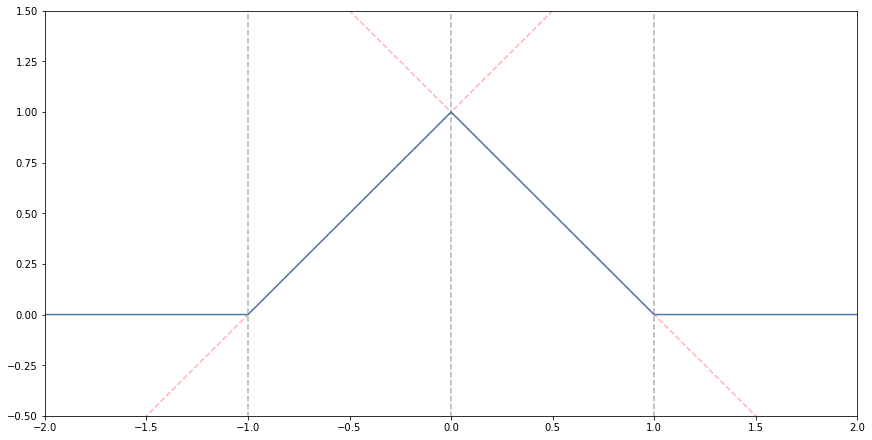

In [4]:
fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 6))

x = scipy_fft.fftshift(sampling_lattice(405, pitch=0.01))
y = np.zeros_like(x)

ax.set_xlim(-2, 2)
ax.set_ylim(-0.5, 1.5)

mask = np.logical_and(x > -1, x < 0)
y[mask] = 1 + x[mask]
mask = np.logical_and(x >= 0, x < 1)
y[mask] = 1 - x[mask]

ax.plot(x, 1 + x, 'r--', alpha=0.3)
ax.plot(x, 1 - x, 'r--', alpha=0.3)
ax.plot(np.repeat([-1, 0, 1], 3), np.tile([-99, 99, np.nan], 3), 'k--', alpha=0.3)
ax.plot(x, y, color='lfd:signal')
pass

$$ \begin{align*}
    \Lambda(x) = \begin{cases}
        1 - |x| & \text{if} \quad |x| < 1 \\
        0 & \text{otherwise}
        \end{cases}
    = \begin{cases}
        1 + x & \text{if} \quad -1 < x < 0 \\
        1 - x & \text{if} \quad 0 \leq x < 1 \\
        0 & \text{otherwise}
        \end{cases} && (14.1)\\
\end{align*} $$

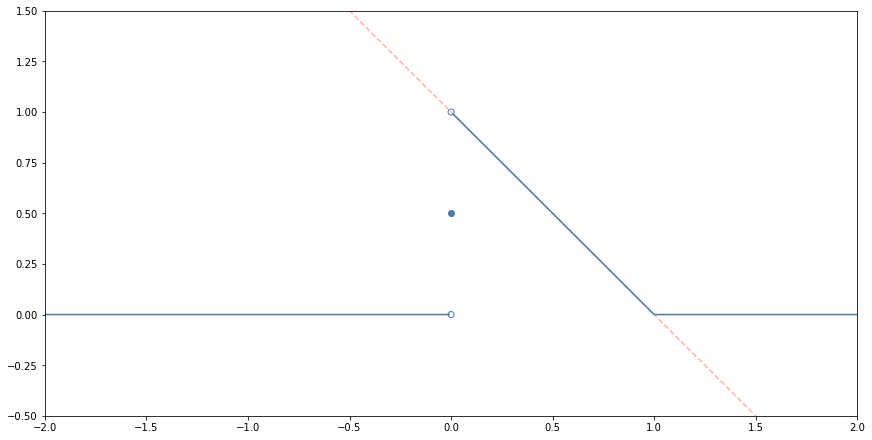

In [5]:
fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 6))

x = scipy_fft.fftshift(sampling_lattice(405, pitch=0.01))
y = np.zeros_like(x)

ax.set_xlim(-2, 2)
ax.set_ylim(-0.5, 1.5)

mask = np.logical_and(x > 0, x < 1)
y[mask] = 1 - x[mask]

y[x==0] = np.nan

ax.plot(x, 1 - x, 'r--', alpha=0.3)
ax.plot(np.repeat([0, 1], 3), np.tile([99, np.nan], 3), 'k--', alpha=0.3)
ax.plot(x, y, color='lfd:signal')

ax.scatter([0], [0.5], color='lfd:signal', zorder=3)
ax.scatter([0, 0], [0, 1], facecolors='none', edgecolors='lfd:signal', zorder=3)
pass

$$ \begin{align*}
    \Gamma(x) = \begin{cases}
        0.5 & \text{if} \quad x = 0 \\
        1 - x & \text{if} \quad 0 < x < 1 \\
        0 & \text{otherwise}
        \end{cases} && (14.2)\\
\end{align*} $$

$$ \begin{align*}
    \Lambda(x) = \Gamma(x) + \Gamma(-x) && (14.3)\\
\end{align*} $$

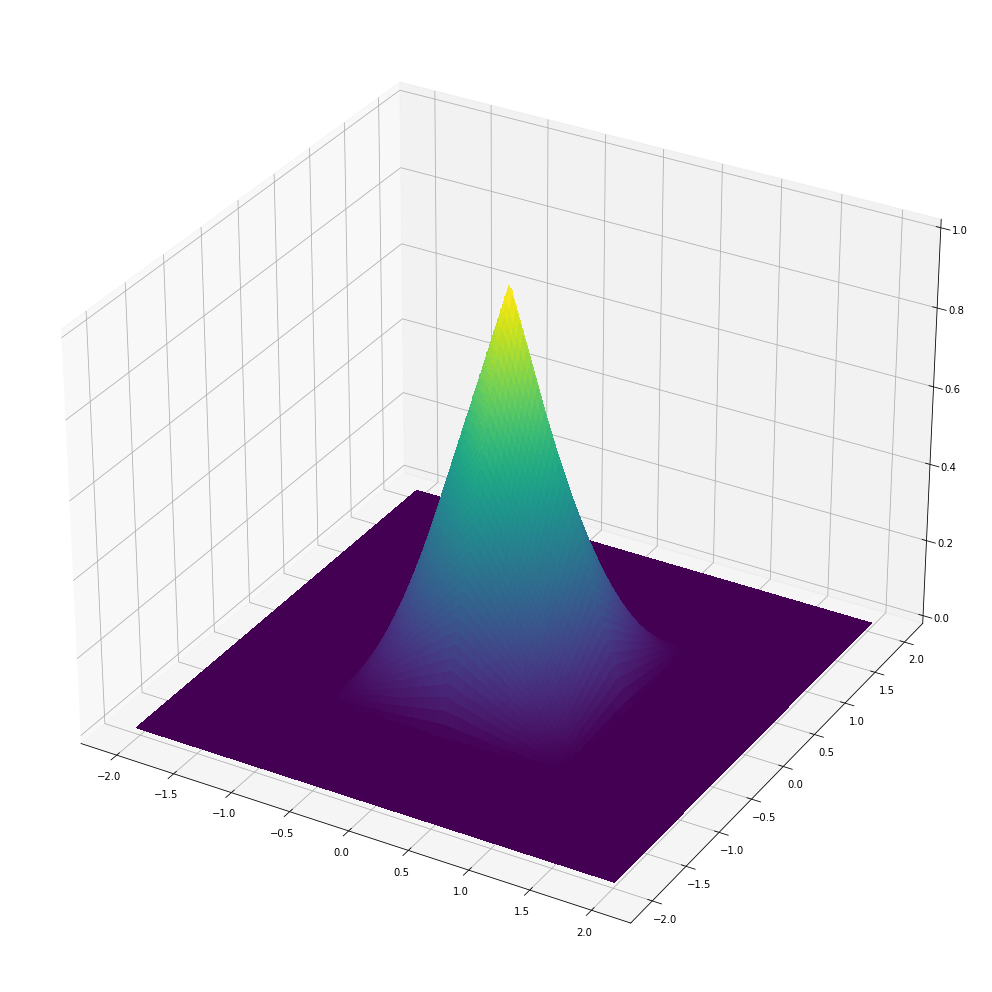

In [6]:
fig = pyplot.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

x = scipy_fft.fftshift(sampling_lattice(405, pitch=0.01))
x_a_over_ab, x_b_over_ab = np.meshgrid(x, x)
phi_d = (1 - np.abs(x_a_over_ab)) * (1 - np.abs(x_b_over_ab))

mask = np.logical_or(np.abs(x_a_over_ab) >= 1, np.abs(x_b_over_ab) >= 1)
phi_d[mask] = 0

ax.plot_surface(x_a_over_ab, x_b_over_ab, phi_d, rstride=3, cstride=3, linewidth=0, shade=False, antialiased=False, cmap=cm.get_cmap())
pass

$$ \begin{align*}
    \Lambda(x_a, x_b) = \Lambda(x_a) \Lambda(x_b) = \begin{cases}
        (1 - |x_a|)(1 - |x_b|) & \text{if} \quad |x_a| < 1 \;,\; |x_b| < 1 \\
        0 & \text{otherwise}
        \end{cases}
    = \begin{cases}
        (1 + x_a)(1 + x_b) & \text{if} \quad -1 < x_a < 0 \;,\; -1 < x_b < 0 \\
        (1 - x_a)(1 + x_b) & \text{if} \quad 0 \leq x_a < 1 \;,\; -1 < x_b < 0 \\
        (1 + x_a)(1 - x_b) & \text{if} \quad -1 < x_a < 0 \;,\; 0 \leq x_b < 1 \\
        (1 - x_a)(1 - x_b) & \text{if} \quad 0 \leq x_a < 1 \;,\; 0 \leq x_b < 1 \\
        0 & \text{otherwise}
        \end{cases} && (14.4)\\
\end{align*} $$

$$ \begin{align*}
    \Lambda(x_a, x_b) = \Gamma(x_a) \Gamma(x_b) + \Gamma(-x_a) \Gamma(x_b) + \Gamma(x_a) \Gamma(-x_b) + \Gamma(-x_a) \Gamma(-x_b)&& (14.5)\\
\end{align*} $$

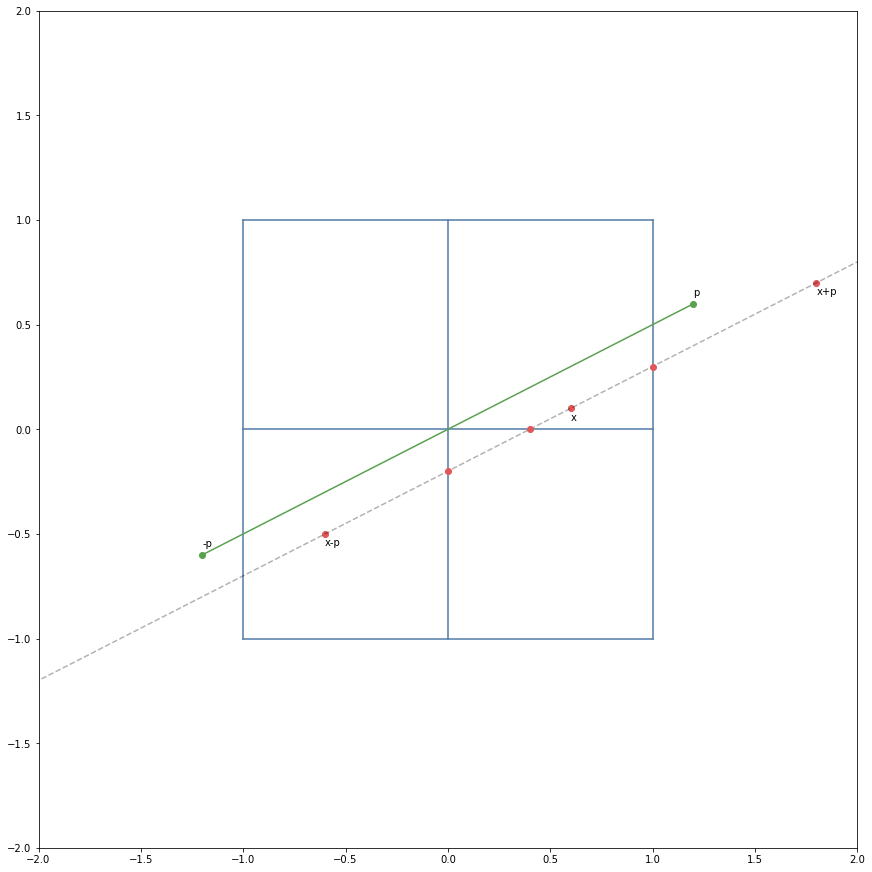

In [7]:
fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 12))

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# y = x * 0.5

p_a = 1.2
p_b = 0.6

ax.plot(np.repeat([-1, 0, 1], 3), np.tile([-1, 1, np.nan], 3), color='lfd:signal')
ax.plot(np.tile([-1, 1, np.nan], 3), np.repeat([-1, 0, 1], 3), color='lfd:signal')
ax.plot(p_a * np.array([-1, 1]), p_b * np.array([-1, 1]), color='lfd:pupil')
ax.scatter(p_a * np.array([-1, 1]), p_b * np.array([-1, 1]), color='lfd:pupil', zorder=3)
ax.annotate('p', (p_a, p_b), xytext=(0, 8), textcoords='offset points')
ax.annotate('-p', (-p_a, -p_b), xytext=(0, 8), textcoords='offset points')

x = np.array(0.6)
y = np.array(0.1)

ax.plot(x + p_a * 10 * np.array([-1, 1]), y + p_b * 10 * np.array([-1, 1]), 'k--', alpha=0.3)
ax.scatter(x + p_a * np.array([-1, 0, 1]), y + p_b * np.array([-1, 0, 1]), color='lfd:retina')
ax.scatter([0, x-y*2, 1], [y-x*0.5, 0, y+(1-x)*0.5], color='lfd:retina', zorder=3)
ax.annotate('x', (x, y), xytext=(0, -12), textcoords='offset points')
ax.annotate('x+p', (x+p_a, y+p_b), xytext=(0, -12), textcoords='offset points')
ax.annotate('x-p', (x-p_a, y-p_b), xytext=(0, -12), textcoords='offset points')

pass

$$ \begin{align*}
    \Lambda(x_a, x_b) * \Lambda\left(\frac{x_p}{w_p}\right)
    &= \bigg(\Gamma(x_a) \Gamma(x_b)\bigg) * \Gamma\left(\frac{x_p}{w_p}\right)
    + \bigg(\Gamma(x_a) \Gamma(x_b)\bigg) * \Gamma\left(\frac{-x_p}{w_p}\right) \\
    &+ \bigg(\Gamma(-x_a) \Gamma(x_b)\bigg) * \Gamma\left(\frac{x_p}{w_p}\right)
    + \bigg(\Gamma(-x_a) \Gamma(x_b)\bigg) * \Gamma\left(\frac{-x_p}{w_p}\right) \\
    &+ \bigg(\Gamma(x_a) \Gamma(-x_b)\bigg) * \Gamma\left(\frac{x_p}{w_p}\right)
    + \bigg(\Gamma(x_a) \Gamma(-x_b)\bigg) * \Gamma\left(\frac{-x_p}{w_p}\right) \\
    &+ \bigg(\Gamma(-x_a) \Gamma(-x_b)\bigg) * \Gamma\left(\frac{x_p}{w_p}\right)
    + \bigg(\Gamma(-x_a) \Gamma(-x_b)\bigg) * \Gamma\left(\frac{-x_p}{w_p}\right) && (14.6)\\
\end{align*} $$

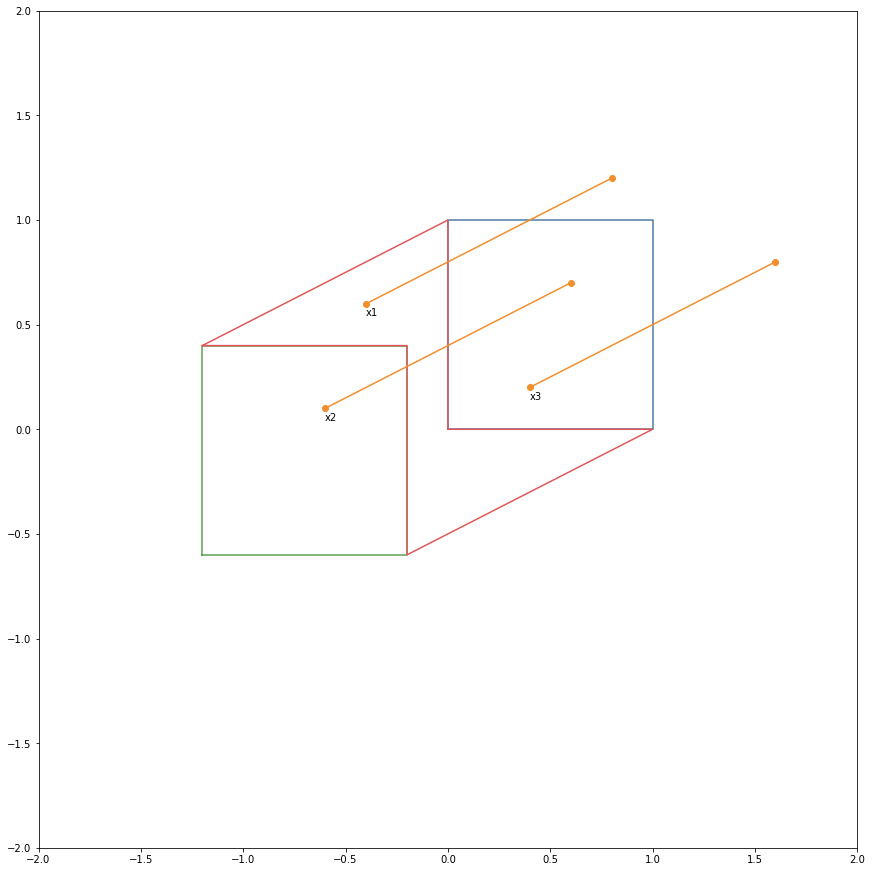

In [8]:
fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 12))

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

p_a = 1.2
p_b = 0.6

ax.plot([0, 0, 1, 1, 0], [0, 1, 1, 0, 0], color='lfd:signal')
ax.plot(np.array([0, 0, 1, 1, 0]) - p_a, np.array([0, 1, 1, 0, 0]) - p_b, color='lfd:pupil')
ax.plot(np.array([0-p_a, 0, 0, 1, 1-p_a, 1-p_a, 0-p_a]), [1-p_b, 1, 0, 0, 0-p_b, 1-p_b, 1-p_b], color='lfd:retina')
ax.plot([0.8-p_a, 0.8], [1.2-p_b, 1.2], color='lfd:filter')
ax.plot([0.6-p_a, 0.6], [0.7-p_b, 0.7], color='lfd:filter')
ax.plot([0.4, 0.4+p_a], [0.2, 0.2+p_b], color='lfd:filter')
ax.scatter([0.8-p_a, 0.8], [1.2-p_b, 1.2], color='lfd:filter', zorder=3)
ax.scatter([0.6-p_a, 0.6], [0.7-p_b, 0.7], color='lfd:filter', zorder=3)
ax.scatter([0.4, 0.4+p_a], [0.2, 0.2+p_b], color='lfd:filter', zorder=3)
ax.annotate('x1', (0.8-p_a, 1.2-p_b), xytext=(0, -12), textcoords='offset points')
ax.annotate('x2', (0.6-p_a, 0.7-p_b), xytext=(0, -12), textcoords='offset points')
ax.annotate('x3', (0.4, 0.2), xytext=(0, -12), textcoords='offset points')

pass

$$ \begin{align*}
    \begin{cases}
        x_a = \frac{d_a}{d_r} x_r + \frac{d_f - d_a}{d_f} x_p \\
        x_b = \frac{d_b}{d_r} x_r + \frac{d_f - d_b}{d_f} x_p \\
    \end{cases}
    = \begin{cases}
        x_a = \alpha_r x_r + \alpha_p x_p \\
        x_b = \beta_r x_r + \beta_p x_p \\
    \end{cases} && (14.7)\\
\end{align*} $$

$$ \begin{align*}
    \begin{cases}
        x_r = \frac{d_r}{d_a - d_b} \left( \frac{d_f - d_b}{d_f} x_a + \frac{d_f - d_a}{d_f} x_b \right) \\
        x_p = \frac{d_b}{d_b - d_a} x_a + \frac{d_a}{d_a - d_b} x_b \\
    \end{cases}
    = \begin{cases}
        x_r = \frac{1}{\alpha_r \beta_p - \alpha_p \beta_r} \left( \beta_p x_a - \alpha_p x_b \right) \\
        x_p = \frac{1}{\alpha_r \beta_p - \alpha_p \beta_r} \left( -\beta_r x_a + \alpha_r x_b \right) \\
    \end{cases} && (14.8)\\
\end{align*} $$

$$ \begin{align*}
    \Bigg[ \Gamma\!\!\left(\frac{x_a}{w_a}\right) \Gamma\!\!\left(\frac{x_b}{w_b}\right)\Bigg] * \Gamma\!\!\left(\frac{x_p}{w_p}\right)
    = \int_{l(x_r)}^{u(x_r)} &\left( 1 - \frac{\alpha_r}{w_a} x_r - \frac{\alpha_p}{w_a} \tau \right) \left( 1 - \frac{\beta_r}{w_b} x_r - \frac{\beta_p}{w_b} \tau \right)
    \left( 1 - \frac{1}{w_p} x_p + \frac{1}{w_p} \tau \right) \mathrm{d}\tau \\
    = \int_{l(x_r)}^{u(x_r)} &\Bigg\{ \left( -\frac{\alpha_p}{w_a} \right) \left( -\frac{\beta_p}{w_b} \right) \left( \frac{1}{w_p} \right) \tau^3 \\
    &+ \left[ \left( 1 - \frac{\alpha_r}{w_a} x_r \right) \left( -\frac{\beta_p}{w_b} \right) \left( \frac{1}{w_p} \right)
           + \left( -\frac{\alpha_p}{w_a} \right) \left( 1 - \frac{\beta_r}{w_b} x_r \right) \left( \frac{1}{w_p} \right)
           + \left( -\frac{\alpha_p}{w_a} \right) \left( -\frac{\beta_p}{w_b} \right) \left( 1 - \frac{1}{w_p} x_p \right) \right] \tau^2 \\
    &+ \left[ \left( -\frac{\alpha_p}{w_a} \right) \left( 1 - \frac{\beta_r}{w_b} x_r \right) \left( 1 - \frac{1}{w_p} x_p \right)
           + \left( 1 - \frac{\alpha_r}{w_a} x_r \right) \left( -\frac{\beta_p}{w_p} \right) \left( 1 - \frac{1}{w_p} x_p \right)
           + \left( 1 - \frac{\alpha_r}{w_a} x_r \right) \left( 1 - \frac{\beta_r}{w_b} x_r \right) \left( \frac{1}{w_p} \right) \right] \tau \\
    &+ \left( 1 - \frac{\alpha_r}{w_a} x_r \right) \left( 1 - \frac{\beta_r}{w_b} x_r \right) \left( 1 - \frac{1}{w_p} x_p \right) \Bigg\} \mathrm{d}\tau \\
    = &\Bigg\{ \left( -\frac{\alpha_p}{w_a} \right) \left( -\frac{\beta_p}{w_b} \right) \left( \frac{1}{w_p} \right) \frac{\tau^4}{4} \\
    &+ \left[ \left( 1 - \frac{\alpha_r}{w_a} x_r \right) \left( -\frac{\beta_p}{w_b} \right) \left( \frac{1}{w_p} \right)
           + \left( -\frac{\alpha_p}{w_a} \right) \left( 1 - \frac{\beta_r}{w_b} x_r \right) \left( \frac{1}{w_p} \right)
           + \left( -\frac{\alpha_p}{w_a} \right) \left( -\frac{\beta_p}{w_b} \right) \left( 1 - \frac{1}{w_p} x_p \right) \right] \frac{\tau^3}{3} \\
    &+ \left[ \left( -\frac{\alpha_p}{w_a} \right) \left( 1 - \frac{\beta_r}{w_b} x_r \right) \left( 1 - \frac{1}{w_p} x_p \right)
           + \left( 1 - \frac{\alpha_r}{w_a} x_r \right) \left( -\frac{\beta_p}{w_p} \right) \left( 1 - \frac{1}{w_p} x_p \right)
           + \left( 1 - \frac{\alpha_r}{w_a} x_r \right) \left( 1 - \frac{\beta_r}{w_b} x_r \right) \left( \frac{1}{w_p} \right) \right] \frac{\tau^2}{2} \\
    &+ \left( 1 - \frac{\alpha_r}{w_a} x_r \right) \left( 1 - \frac{\beta_r}{w_b} x_r \right) \left( 1 - \frac{1}{w_p} x_p \right) \tau \Bigg\} \Bigg|_{l(x_r)}^{u(x_r)} && (14.9)\\
\end{align*} $$